In [7]:
%matplotlib inline
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from jupyterthemes import jtplot #for making plots appear with same theme
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)

## Data Preprocessing

In [8]:
#indicate dataset path
data_dir = "C:\\Users\\kmens\Desktop\\Fourth Year\\4ML3\\Project\\archive\\NEU Metal Surface Defects Data"
os.listdir(data_dir)

['gen_test', 'gen_train', 'test', 'Thumbs.db', 'train', 'valid']

In [9]:
#test & train paths
test_path = data_dir+'\\test\\'
train_path = data_dir+'\\train\\'
gen_train = data_dir + "\\gen_train\\"
gen_test = data_dir + "\\gen_test\\"

In [10]:
#view folders in test path
os.listdir(test_path)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

In [11]:
#pick a random image 
random_inclusion = train_path + "Inclusion\\" + os.listdir(train_path+"Inclusion")[0]
random_inclusion = np.expand_dims(imread(random_inclusion), axis=-1)
#Images must be read as (200,200,1) shape
#check shape
random_inclusion.shape

(200, 200, 1)

In [12]:
train_path + "Inclusion\\" + os.listdir(train_path+"Inclusion")[0]

'C:\\Users\\kmens\\Desktop\\Fourth Year\\4ML3\\Project\\archive\\NEU Metal Surface Defects Data\\train\\Inclusion\\In_120.bmp'

In [13]:
"""
cv2.imshow('sample input', random_inclusion)
cv2.waitKey(0)
cv2.destroyAllWindows()
"""

"\ncv2.imshow('sample input', random_inclusion)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n"

In [14]:
#initialize image transformer
data_gen = ImageDataGenerator(rotation_range=15, width_shift_range=0.05, height_shift_range=0.05,
                              shear_range = 0.1, horizontal_flip=True,vertical_flip=True, 
                              fill_mode = 'constant')

In [15]:
"""
cv2.imshow("transformed img", data_gen.random_transform(random_inclusion))
cv2.waitKey(0)
cv2.destroyAllWindows()
"""

'\ncv2.imshow("transformed img", data_gen.random_transform(random_inclusion))\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n'

In [16]:
#plt.imshow with "gray" brightens grayscale images too much
#cv2.imshow shows real colors

### Save x_train & y_train

In [17]:
#CLEAR DIRECTORY BEFORE RUNNING A SECOND TIME
#generate one large batch as dataset
#train directory with image transformer
train_gen = data_gen.flow_from_directory(train_path,
                                         target_size=(200,200),
                                         color_mode="grayscale",
                                         class_mode="sparse",
                                         batch_size=900,
                                         shuffle=True,
                                         save_to_dir=gen_train)

for i in range(1):
    x_train, y_train = train_gen.next()
    
x_train = x_train/255
x_train = np.squeeze(x_train, axis=-1)

Found 1656 images belonging to 6 classes.


In [18]:
train_gen.class_indices

{'Crazing': 0,
 'Inclusion': 1,
 'Patches': 2,
 'Pitted': 3,
 'Rolled': 4,
 'Scratches': 5}

### Save x_test & y_test

In [19]:
#CLEAR DIRECTORY BEFORE RUNNING A SECOND TIME
#generate one large batch as dataset
#test directory with image transformer
test_gen = data_gen.flow_from_directory(test_path,
                                        target_size=(200,200),
                                        color_mode="grayscale",
                                        class_mode="sparse",
                                        batch_size=72,
                                        shuffle=True,
                                        save_to_dir=gen_test)

for i in range(1):
    x_test, y_test = test_gen.next()
    
x_test = x_test/255
x_test = np.squeeze(x_test, axis=-1)
x_train.shape

Found 72 images belonging to 6 classes.


(900, 200, 200)

In [20]:
#make sure labels are integers
y_train = y_train.astype("uint8")
y_test = y_test.astype("uint8")
y_test

array([1, 3, 4, 5, 4, 3, 2, 1, 5, 0, 1, 1, 5, 2, 0, 3, 1, 0, 4, 3, 2, 5,
       3, 0, 1, 3, 4, 4, 0, 2, 1, 1, 1, 4, 1, 3, 2, 5, 4, 0, 3, 3, 1, 1,
       0, 0, 5, 2, 5, 2, 2, 4, 3, 4, 0, 2, 5, 0, 2, 4, 5, 3, 3, 5, 5, 2,
       0, 4, 2, 5, 4, 0], dtype=uint8)

In [21]:
200*200

40000

## Autoencoder

In [22]:
#downsampling
encoder = Sequential()
encoder.add(Flatten(input_shape=[200,200]))
encoder.add(Dense(1250,activation="relu"))
encoder.add(Dense(625,activation="relu"))
encoder.add(Dense(312,activation="relu"))
encoder.add(Dense(156,activation="relu"))

#upsampling
decoder = Sequential()
decoder.add(Dense(312, input_shape=[156],activation='relu'))
decoder.add(Dense(625,activation='relu'))
decoder.add(Dense(1250,activation='relu'))
decoder.add(Dense(40000,activation='sigmoid'))
decoder.add(Reshape([200,200]))

In [23]:
#put together the encoder and decoder
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])

In [24]:
#train the autoencoder
autoencoder.fit(x_train, x_train, epochs=500,validation_data=(x_test, x_test))

Epoch 1/500
29/29 [==============================] - 3s 29ms/step - loss: 0.6816 - accuracy: 0.0039 - val_loss: 0.6829 - val_accuracy: 0.0042
Epoch 2/500
29/29 [==============================] - 1s 22ms/step - loss: 0.6764 - accuracy: 0.0045 - val_loss: 0.6803 - val_accuracy: 0.0035
Epoch 3/500
29/29 [==============================] - 1s 22ms/step - loss: 0.6741 - accuracy: 0.0039 - val_loss: 0.6801 - val_accuracy: 0.0040
Epoch 4/500
29/29 [==============================] - 1s 22ms/step - loss: 0.6725 - accuracy: 0.0046 - val_loss: 0.6752 - val_accuracy: 0.0040
Epoch 5/500
29/29 [==============================] - 1s 22ms/step - loss: 0.6629 - accuracy: 0.0050 - val_loss: 0.6699 - val_accuracy: 0.0081
Epoch 6/500
29/29 [==============================] - 1s 22ms/step - loss: 0.6417 - accuracy: 0.0066 - val_loss: 0.6487 - val_accuracy: 0.0074
Epoch 7/500
29/29 [==============================] - 1s 22ms/step - loss: 0.6221 - accuracy: 0.0085 - val_loss: 0.6423 - val_accuracy: 0.0089
Epoch 

KeyboardInterrupt: 

### Testing

In [ ]:
input_images = x_test[0,10]
denoised = autoencoder(x_test[0:10])

In [ ]:
n=3

print("Input")
plt.imshow(x_test[n], cmap="gray")
plt.show()
print("Output")
plt.imshow(denoised[n], cmap="gray")
plt.show()

In [ ]:
metrics = pd.DataFrame(autoencoder.history.history)

In [ ]:
metrics[['accuracy','val_accuracy']].plot(figsize=(14,8))
plt.title("Accuracy History")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [ ]:
metrics[['loss','val_loss']].plot(figsize=(14,8))
plt.title("Loss History")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim((0,3))

In [ ]:
autoencoder.summary()

In [ ]:
autoencoder.save("Denoiser.h5")

In [ ]:
autoencoder = tf.keras.models.load_model("Denoiser.h5")

In [26]:
metrics = pd.DataFrame(autoencoder.history.history)

In [27]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.681630,0.003906,0.682938,0.004167
1,0.676444,0.004461,0.680344,0.003472
2,0.674076,0.003867,0.680079,0.004028
3,0.672520,0.004617,0.675195,0.003958
4,0.662904,0.004972,0.669886,0.008056
5,0.641688,0.006644,0.648707,0.007361
6,0.622109,0.008478,0.642312,0.008889
7,0.616367,0.008617,0.628330,0.010625
8,0.609360,0.009772,0.622791,0.011597
9,0.603902,0.012689,0.619730,0.013958


(0.5, 0.7)

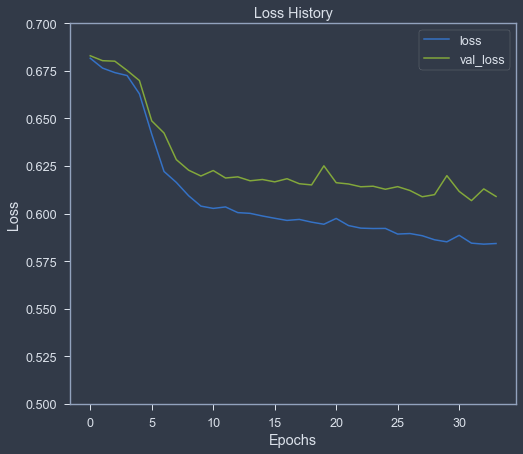

In [33]:
metrics[['loss','val_loss']].plot()
plt.title("Loss History")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim((0.5, 0.7))